In [2]:
from cftime import DatetimeNoLeap
import xarray as xr
import sys, os, os.path, datetime, glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
import xarray as xr
plt.rcParams['figure.dpi'] = 300

import pandas as pd
#from mpl_toolkits.basemap import Basemap
# [OK]: import geoplots as gt
# [OK]: from geoplots import geoplot, fxyplot, mapplot, xticksyear
# [OK]: import geoxarray
# [OK]: import filter
# [OK]: import xlearn
# [OK]: import mysignal as sig


In [3]:
def extract_volc_info(forcing_file, threshold=1e-6):
    '''extract volcanic eruption information'''
    ds = xr.open_dataset(forcing_file)
    print(forcing_file)

    # cftime_range
    s = ds.date[0].astype('int').astype('str').item()
    date_start = f'{int(s[:-4]):04d}' + '-' + s[-4:-2]
    print(date_start)
    s = ds.date[-1].astype('int').astype('str').item()
    date_end = f'{int(s[:-4]):04d}' + '-' + s[-4:-2]
    print(date_end)
    time_noleap = xr.cftime_range(date_start, date_end, freq='MS', calendar='noleap')
    # print('time_noleap:', time_noleap)

    # eruption start/end dates
    ts = ds.colmass.expand_dims('lon', axis=-1).geo.fldmean() \
        .pipe(lambda x: (x>threshold).astype('int')) \
        .assign_coords(time=time_noleap) 
    t_erupt_starts = ts.diff(dim='time').pipe(lambda x: x[x==1]).time
    t_erupt_ends = ts.diff(dim='time', label='lower').pipe(lambda x: x[x==-1]).time
    # print('t_erupt_starts:', t_erupt_starts)
    # print('t_erupt_ends:', t_erupt_ends)

    # colmass global/NH-time-mean, global-mean-time-max/argmax(peak date)
    colmass_global = []
    colmass_nh = []
    colmass_peaks = []
    t_erupt_peaks = []
    for t0,t1 in zip(t_erupt_starts, t_erupt_ends):
        da = ds.colmass.assign_coords(time=time_noleap).sel(time=slice(t0, t1)).expand_dims('lon', axis=-1)
        g = da.geo.fldmean().sum('time').item()/12 #kg/m^2*year
        nh = da.sel(lat=slice(0,90)).geo.fldmean().sum('time').item()/12
        p = da.geo.fldmean().max('time').item()
        t_p = da.geo.fldmean().pipe(lambda x: x.isel(time=x.argmax('time')).time).item()
        colmass_global.append(g)
        colmass_nh.append(nh)
        colmass_peaks.append(p)
        t_erupt_peaks.append(t_p)
    # print(t0.item(), t1.item(), g, nh, p, t_p)

    # DataFrame
    df = pd.DataFrame({'t_erupt_start': t_erupt_starts,
                     't_erupt_peak': t_erupt_peaks,
                     't_erupt_end': t_erupt_ends,
                     'colmass_global': colmass_global,
                     'colmass_nh': colmass_nh,
                     'colmass_peak': colmass_peaks})
    
    df['colmass_sh'] = df['colmass_global'] * 2 - df['colmass_nh']
    df['colmass_asy'] = ( df['colmass_nh'] - df['colmass_sh'] )/2/df['colmass_global']
    
    return df

In [4]:
# data
ifile = '/tigress/wenchang/data/cesm/LME/FORCING/IVI2LoadingLatHeight501-2000_L18_c20100518.nc'
ds = xr.open_dataset(ifile)
ds850 = ds
ds

<xarray.Dataset>
Dimensions:  (lat: 64, lev: 18, time: 18002)
Coordinates:
  * time     (time) float32 500.95834 501.0417 501.125 ... 2000.9584 2001.0416
  * lev      (lev) float32 4.8093 13.073097 32.5591 ... 929.276 970.4459 992.528
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
Data variables:
    MMRVOLC  (time, lev, lat) float64 ...
    colmass  (time, lat) float32 ...
    datesec  (time) float64 ...
    date     (time) float64 ...
Attributes:
    title:          IVI2LoadingLatHeight501-2000.bin converted to 18 pressure...
    reference:      Gao,Robock,and Ammann,2008:J. Geophys. Res,doi:10.1029/20...
    created_by:     hteng: copper.cgd.ucar.edu:/datalocal/ccpa/hteng/volcano/...
    creation_date:   2010-05-18
    modification:   Z2P is based on ccsm4.p2z.nc, derived from b40.1850.track...

In [5]:
time_noleap = xr.cftime_range('0500-12', '2001-01', freq='MS', calendar='noleap')#.shift(14, 'D')
time_noleap

CFTimeIndex([0500-12-01 00:00:00, 0501-01-01 00:00:00, 0501-02-01 00:00:00,
             0501-03-01 00:00:00, 0501-04-01 00:00:00, 0501-05-01 00:00:00,
             0501-06-01 00:00:00, 0501-07-01 00:00:00, 0501-08-01 00:00:00,
             0501-09-01 00:00:00,
             ...
             2000-04-01 00:00:00, 2000-05-01 00:00:00, 2000-06-01 00:00:00,
             2000-07-01 00:00:00, 2000-08-01 00:00:00, 2000-09-01 00:00:00,
             2000-10-01 00:00:00, 2000-11-01 00:00:00, 2000-12-01 00:00:00,
             2001-01-01 00:00:00],
            dtype='object', length=18002)

In [6]:
def fig_colmass(period=850):
    '''
    '''
    if period == 850:
        ds = ds850
    elif period == 1850:
        ds = ds1850
    else:
        print('period is either 850 or 1850')
        return
    ima = ds.colmass.plot(robust=True, x='time', figsize=(10,3), vmin=1e-6,vmax=4e-6,cmap='Reds',add_labels=False,add_colorbar=False)
    plt.axhline(0, color='gray', ls='--')    
    plt.title(ds.attrs['title'])
    plt.tight_layout()

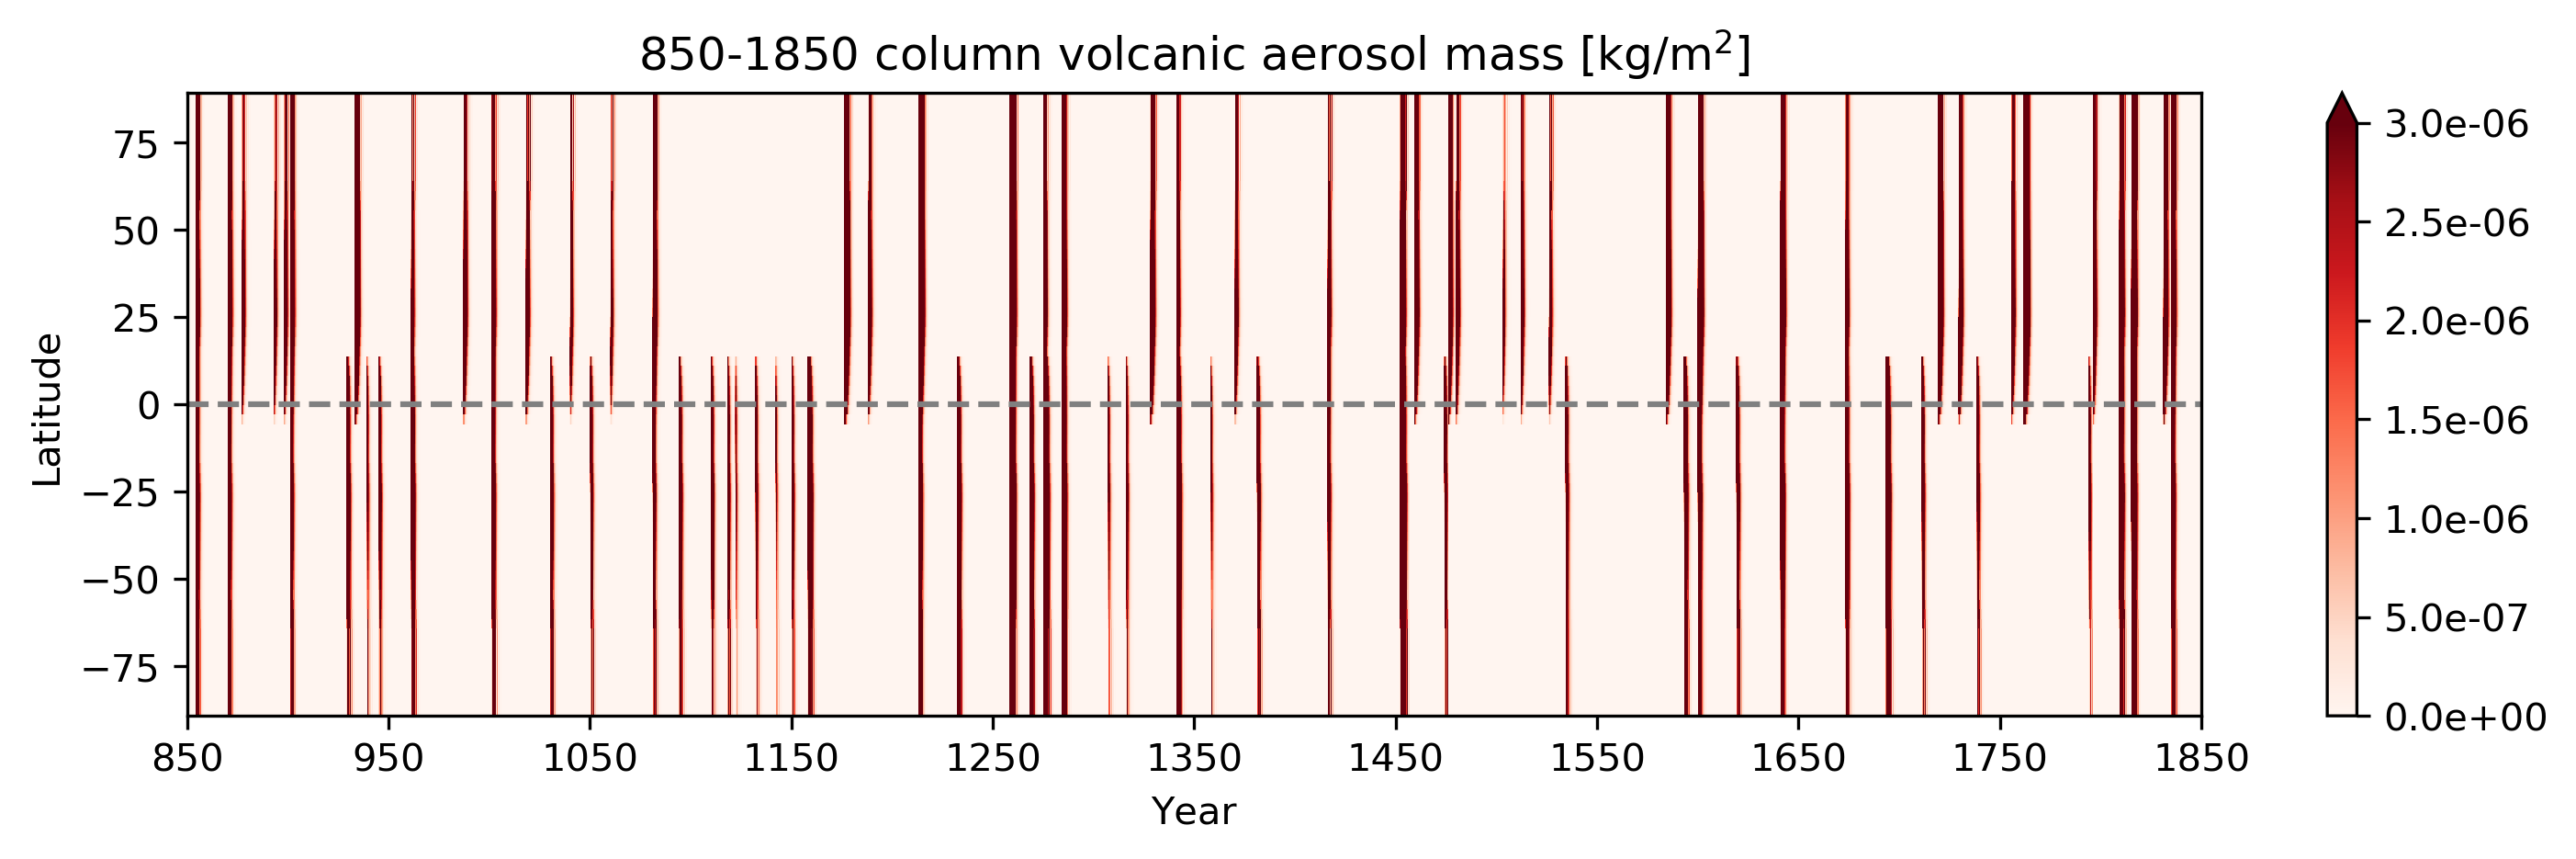

In [162]:
ima = ds.colmass.plot(robust=True, x='time', figsize=(10,3), vmin=0,vmax=3e-6,cmap='Reds',add_labels=False,add_colorbar=False)
plt.axhline(0, color='gray', ls='--')    
plt.title(ds.attrs['title'])
plt.tight_layout()
plt.xlim(850, 1850)
plt.xticks(range(850, 1851, 100))
plt.ylabel('Latitude')

plt.xlabel('Year')
plt.title('850-1850 column volcanic aerosol mass [kg/m$^2$]')
cbar=plt.colorbar(ima,extend='max')
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels([f'{x:.1e}' for x in cbar.get_ticks()])

#plt.savefig('850forcing.png',bbox_inches='tight')

In [163]:
ifile = '/tigress/wenchang/data/cesm/LME/FORCING/CCSM4_volcanic_1850-2008_prototype1.nc'
ds = xr.open_dataset(ifile)
ds1850 = ds
ds


<xarray.Dataset>
Dimensions:  (lat: 64, lev: 8, time: 1910)
Coordinates:
  * time     (time) float32 1849.9166 1850.0 1850.0833 ... 2008.9166 2009.0
  * lev      (lev) float32 9.8 21.0 37.2303 ... 85.43912 100.51469 118.25033
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
Data variables:
    date     (time) float64 ...
    MMRVOLC  (time, lev, lat) float64 ...
    colmass  (time, lat) float32 ...
    datesec  (time) float64 ...
Attributes:
    title:                 Volcanic Aerosol Mass Mixing Ratio Prototype Dec 1...
    creation_date:         Wed Apr  1 09:13:55 MDT 2009
    created_by:            Caspar Ammann
    reference:             ...
    aerosol_dates:         Covered Period : Monthly averages Dec 1849 - Jan 2...
    aerosol_base:          Derived from CCSM3_volcanic forcing
    aerosol_distribution:  Single aerosol distribution: sulfuric acid with re...

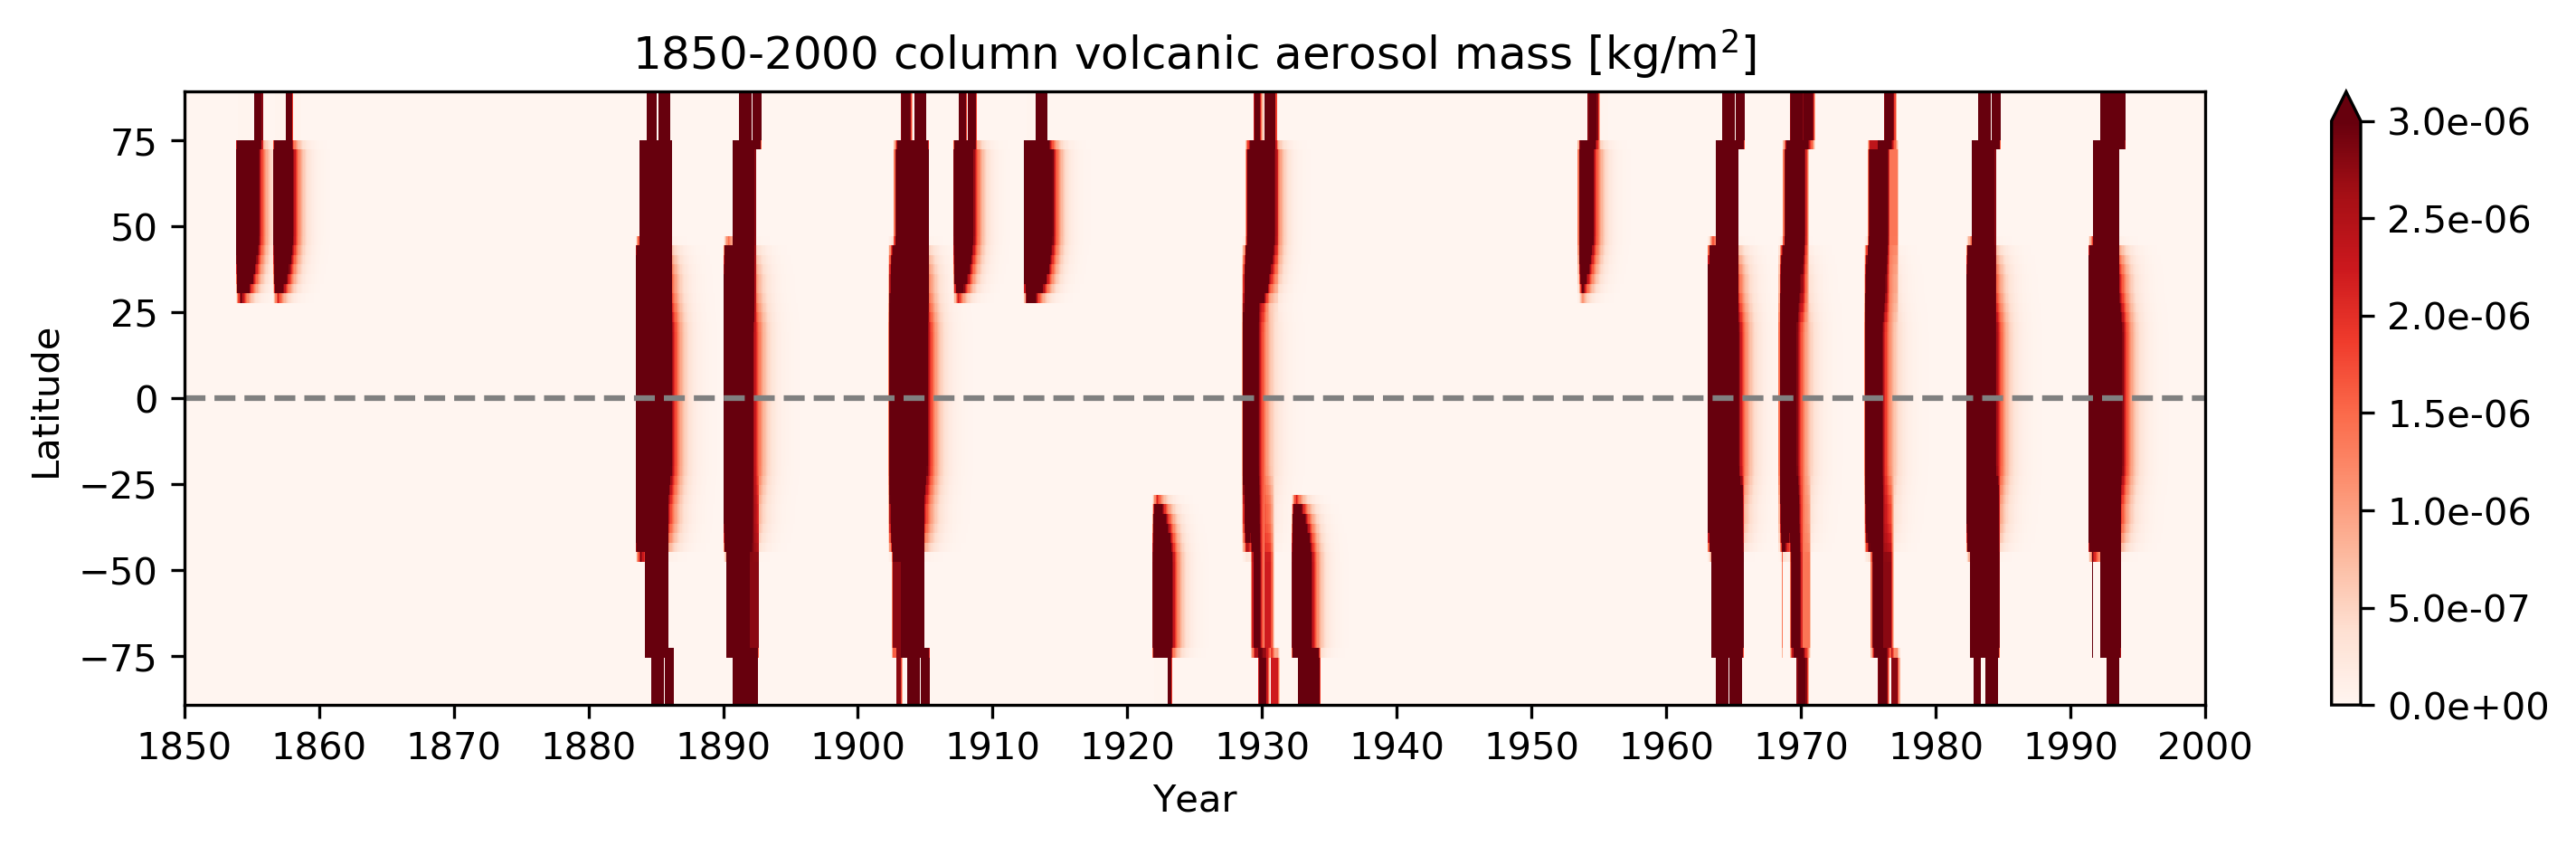

In [166]:
ima = ds.colmass.plot(robust=True, x='time', figsize=(10,3), vmin=0,vmax=3e-6,cmap='Reds',add_labels=False,add_colorbar=False)
plt.axhline(0, color='gray', ls='--')    
plt.title(ds.attrs['title'])
plt.tight_layout()
plt.xlim(year, year+150)
plt.xticks(range(year, year+151, 10))
plt.ylabel('Latitude')
plt.xlabel('Year')
plt.title('1850-2000 column volcanic aerosol mass [kg/m$^2$]')
cbar=plt.colorbar(ima,extend='max')
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels([f'{x:.1e}' for x in cbar.get_ticks()])

#plt.savefig('1850forcing.png',bbox_inches='tight')

In [7]:
# Parameters
data_name = 'extsw_b05'
p = 50
nclist = [{'tag': 'CMIP5', 'ncfile': '/tigress/gvecchi/CM2.5/input/VOLCANIC/CMIP5/extsw_data.nc'},
          {'tag': 'CMIP6', 'ncfile': '/tigress/gvecchi/CM2.5/input/VOLCANIC/CMIP6/extsw_V3_DATATROP_RCP.nc'}
         ]

In [8]:
def ext2aod(ds, band=7):
    '''calculate volcanic aerosol AOD based on extinction coefficient.'''
    Rd = 287#J/K/kg
    T = 300#K
    g = 9.8#m/s**2
    data_name = f'extsw_b{band:02d}'
    if band == 7:
        new_name = 'AOD_550nm'
    else:
        new_name = f'AOD_b{band:02d}'
    da = ds[data_name]
    z = da.pfull.pipe(lambda x: x.isel(pfull=0)/x) \
        .pipe(lambda x: np.log(x))*Rd*T/g
    da = da.rename({'pfull': 'z'}).assign_coords(z=z.values).integrate('z') \
        .rename(new_name)
    
    return da

In [9]:
#for aerosol optical depth
dss = dict()
das = list()
for nc in nclist:
    ncfile = nc['ncfile']
    ds = xr.open_dataset(ncfile)
    da = ext2aod(ds, band=7).mean('lon')
    scale_factor = 1
    da_ = da.pipe(lambda x:x*scale_factor)
    da_['time'] = da_.indexes['time'].to_datetimeindex()
    bbox = {'facecolor': 'w', 'alpha':.5, 'boxstyle': 'round'}
    das.append(da)

da = xr.concat(das, pd.Index([nc['tag'] for nc in nclist], name='Source'))
print(da)

/home/tessj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # Remove the CWD from sys.path while we load stuff.


<xarray.DataArray 'AOD_550nm' (Source: 2, time: 3012, lat: 90)>
array([[[0.00556804, 0.00557296, 0.00557069, ..., 0.00656232,
         0.00657666, 0.00658588],
        [0.00529379, 0.00529958, 0.00529844, ..., 0.00625961,
         0.00627854, 0.00628631],
        [0.00516813, 0.0051727 , 0.00517064, ..., 0.00589716,
         0.00590893, 0.00591592],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.00878986, 0.00878379, 0.00877218, ..., 0.0091296 ,
         0.00912934, 0.00912936],
        [0.00807231, 0.00806701, 0.00805684, ..., 0.01152673,
         0.01152363, 0.01152233],
        [0.00806868, 0.00806465, 0.00805645, ..., 0.01207934,
         0.0120746 , 0.01207256],
        ...,
        [0.01598853, 0.01599424, 0.01600385,

In [168]:
# this is for aerosol extinction coeff
'''dss = dict()
das = list()
for nc in nclist:
    tag = nc['tag']
    ncfile = nc['ncfile']
    ds = xr.open_dataset(ncfile)
    dss[tag] = ds
    da = ds[data_name].isel(lon=0).mean('pfull').load()
    das.append(da)
da = xr.concat(das, pd.Index([nc['tag'] for nc in nclist], name='Source'))
print(da)'''

<xarray.DataArray 'extsw_b05' (Source: 2, time: 3012, lat: 90)>
array([[[3.48717002e-08, 3.49005269e-08, 3.48881066e-08, ...,
         4.03965004e-08, 4.04807068e-08, 4.05330489e-08],
        [3.31969083e-08, 3.32315366e-08, 3.32258523e-08, ...,
         3.85257053e-08, 3.86373848e-08, 3.86818506e-08],
        [3.23113980e-08, 3.23384945e-08, 3.23277263e-08, ...,
         3.63172887e-08, 3.63867727e-08, 3.64269432e-08],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[5.90826694e-08, 5.90547309e-08, 5.90024172e-08, ...,
         6.72616380e-08, 6.72707898e-08, 6.72765310e-08],
        [5.22595265e-08, 5.22368211e-08, 5.21944976e-08, ...,
         8.94552485

In [10]:
def plot_volcanic_forcing(time_slice):
    f = da.sel(time=time_slice).plot(row='Source', y='lat',add_labels=False,vmin=0,vmax=0.000004,cmap='Oranges')
    i=0
    for ax in f.axes.flat:
        plt.sca(ax)
        plt.setp(plt.xticks()[1], rotation=45, ha='right')
        f.cbar.set_ticks(f.cbar.get_ticks())
        f.cbar.set_ticklabels([f'{x:.1e}' for x in f.cbar.get_ticks()])
        f.cbar.set_label('')
        if (i==0):
            plt.xlabel('Year')
            plt.ylabel('Latitude')
        else:
            plt.xlabel('Year')
            plt.ylabel('')
        i+=1
        
    plt.yticks(range(-60,90,30))


In [11]:
stmaria5 = da.sel(time=slice('1902', '1905'),Source='CMIP5')
agung5 = da.sel(time=slice('1963', '1966'),Source='CMIP5')
pinatubo5 = da.sel(time=slice('1991', '1994'),Source='CMIP5')
stmaria6 = da.sel(time=slice('1902', '1905'),Source='CMIP6')
agung6 = da.sel(time=slice('1963', '1966'),Source='CMIP6')
pinatubo6 = da.sel(time=slice('1991', '1994'),Source='CMIP6')

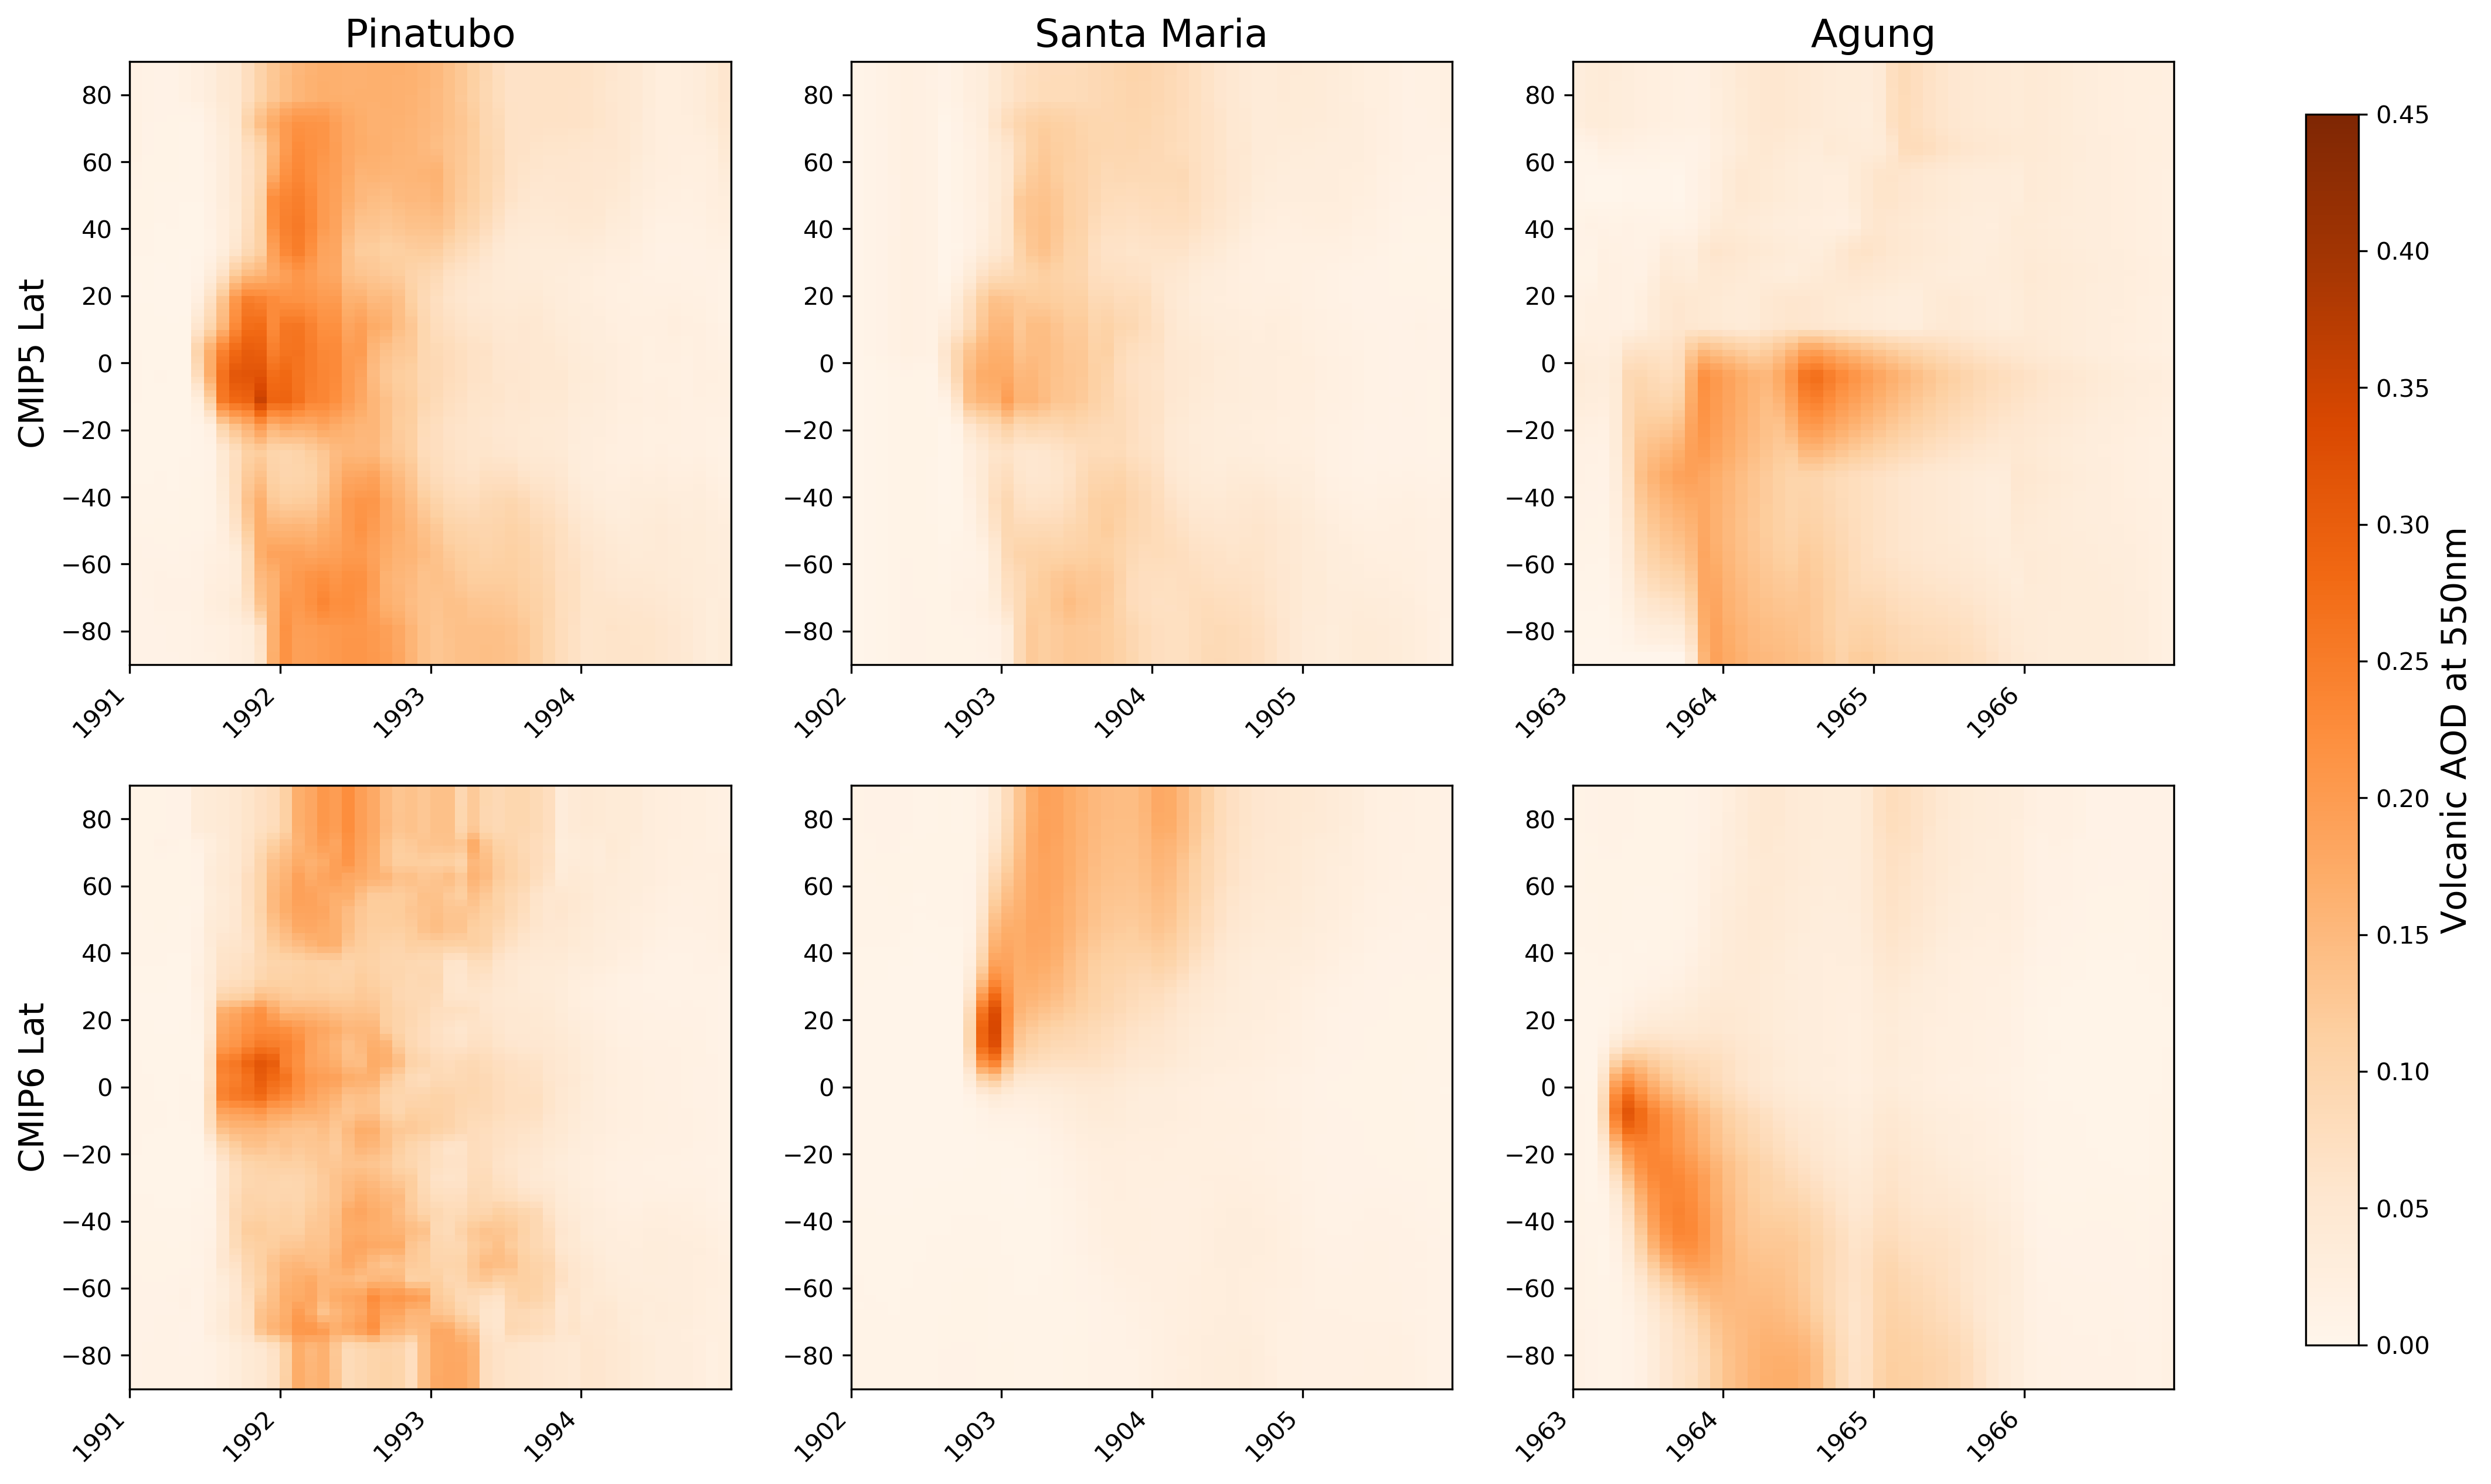

In [14]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
titles=['Pinatubo','Santa Maria', 'Agung']
das = [pinatubo5,stmaria5,agung5,pinatubo6,stmaria6,agung6]

for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(2,3,ii+1)
    plt.sca(ax)
    plt.setp(plt.xticks()[1], rotation=45, ha='right')
    im = das[ii].plot(y='lat',add_labels=False,vmin=0,vmax=0.45,cmap='Oranges',add_colorbar=False)
    if ii<3:
        plt.title(titles[ii],fontsize=16)
    else:
        plt.title('')
    if ii==0:
        plt.ylabel('CMIP5 Lat',fontsize=14)
    elif ii==3:
        plt.ylabel('CMIP6 Lat',fontsize=14)
    else:
        plt.ylabel('')
    
        

ax = fig.add_axes((.95,.15,.02,.7))
cb = plt.colorbar(im, cax=ax,orientation='vertical')
cb.set_ticks(cb.get_ticks())
#cb.set_ticklabels([f'{x:.1e}' for x in cb.get_ticks()])
cb.set_label('Volcanic AOD at 550nm',size=14)

#plt.savefig('cmips.png',bbox_inches='tight')

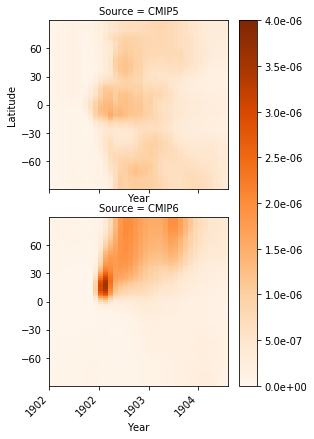

In [59]:
plot_volcanic_forcing(slice('1902', '1904'))
#stmaria
#plt.savefig('cmip_stmaria.png')

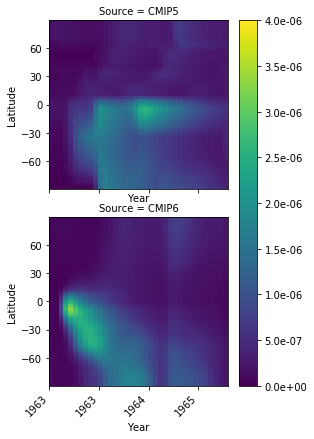

In [55]:
plot_volcanic_forcing(slice('1963', '1965'))
#agung
#plt.savefig('cmip_agung.png')

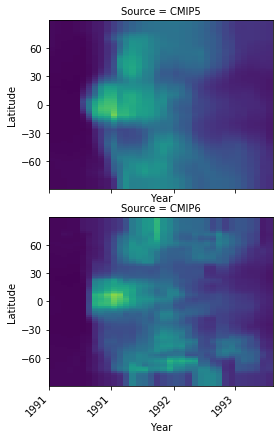

In [50]:
plot_volcanic_forcing(slice('1991', '1993'))
#pinatubo
#plt.savefig('cmip_pinatubo.png')

In [174]:
from datetime import datetime
import os.path, sys, os
import xarray as xr, numpy as np, pandas as pd
import matplotlib.pyplot as plt
f#rom geoplots import yticks2lat, xticksmonth
 
# Parameters
cmip = 'CMIP5'#'CMIP6'
print(cmip)
figname = f'fig.aod550nm.{cmip}.png'
data_name = 'extsw_b07'
if cmip == 'CMIP6':
    ncfile = '/tigress/gvecchi/CM2.5/input/VOLCANIC/CMIP6/extsw_V3_DATATROP_RCP.nc'
elif cmip == 'CMIP5':
    ncfile = '/tigress/gvecchi/CM2.5/input/VOLCANIC/CMIP5/extsw_data.nc'

def ext2aod(ds, band=7):
    '''calculate volcanic aerosol AOD based on extinction coefficient.'''
    Rd = 287#J/K/kg
    T = 300#K
    g = 9.8#m/s**2
    data_name = f'extsw_b{band:02d}'
    if band == 7:
        new_name = 'AOD_550nm'
    else:
        new_name = f'AOD_b{band:02d}'
    da = ds[data_name]
    z = da.pfull.pipe(lambda x: x.isel(pfull=0)/x) \
        .pipe(lambda x: np.log(x))*Rd*T/g
    da = da.rename({'pfull': 'z'}).assign_coords(z=z.values).integrate('z') \
        .rename(new_name)
    
    return da

CMIP5


In [175]:
# data
ds = xr.open_dataset(ncfile)
da = ext2aod(ds, band=7).mean('lon')

# fig, CMIP6 AOD at 550nm
scale_factor = 1
da_ = da.pipe(lambda x:x*scale_factor)
da_['time'] = da_.indexes['time'].to_datetimeindex()
bbox = {'facecolor': 'w', 'alpha':.5, 'boxstyle': 'round'}

/home/tessj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


/home/tessj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


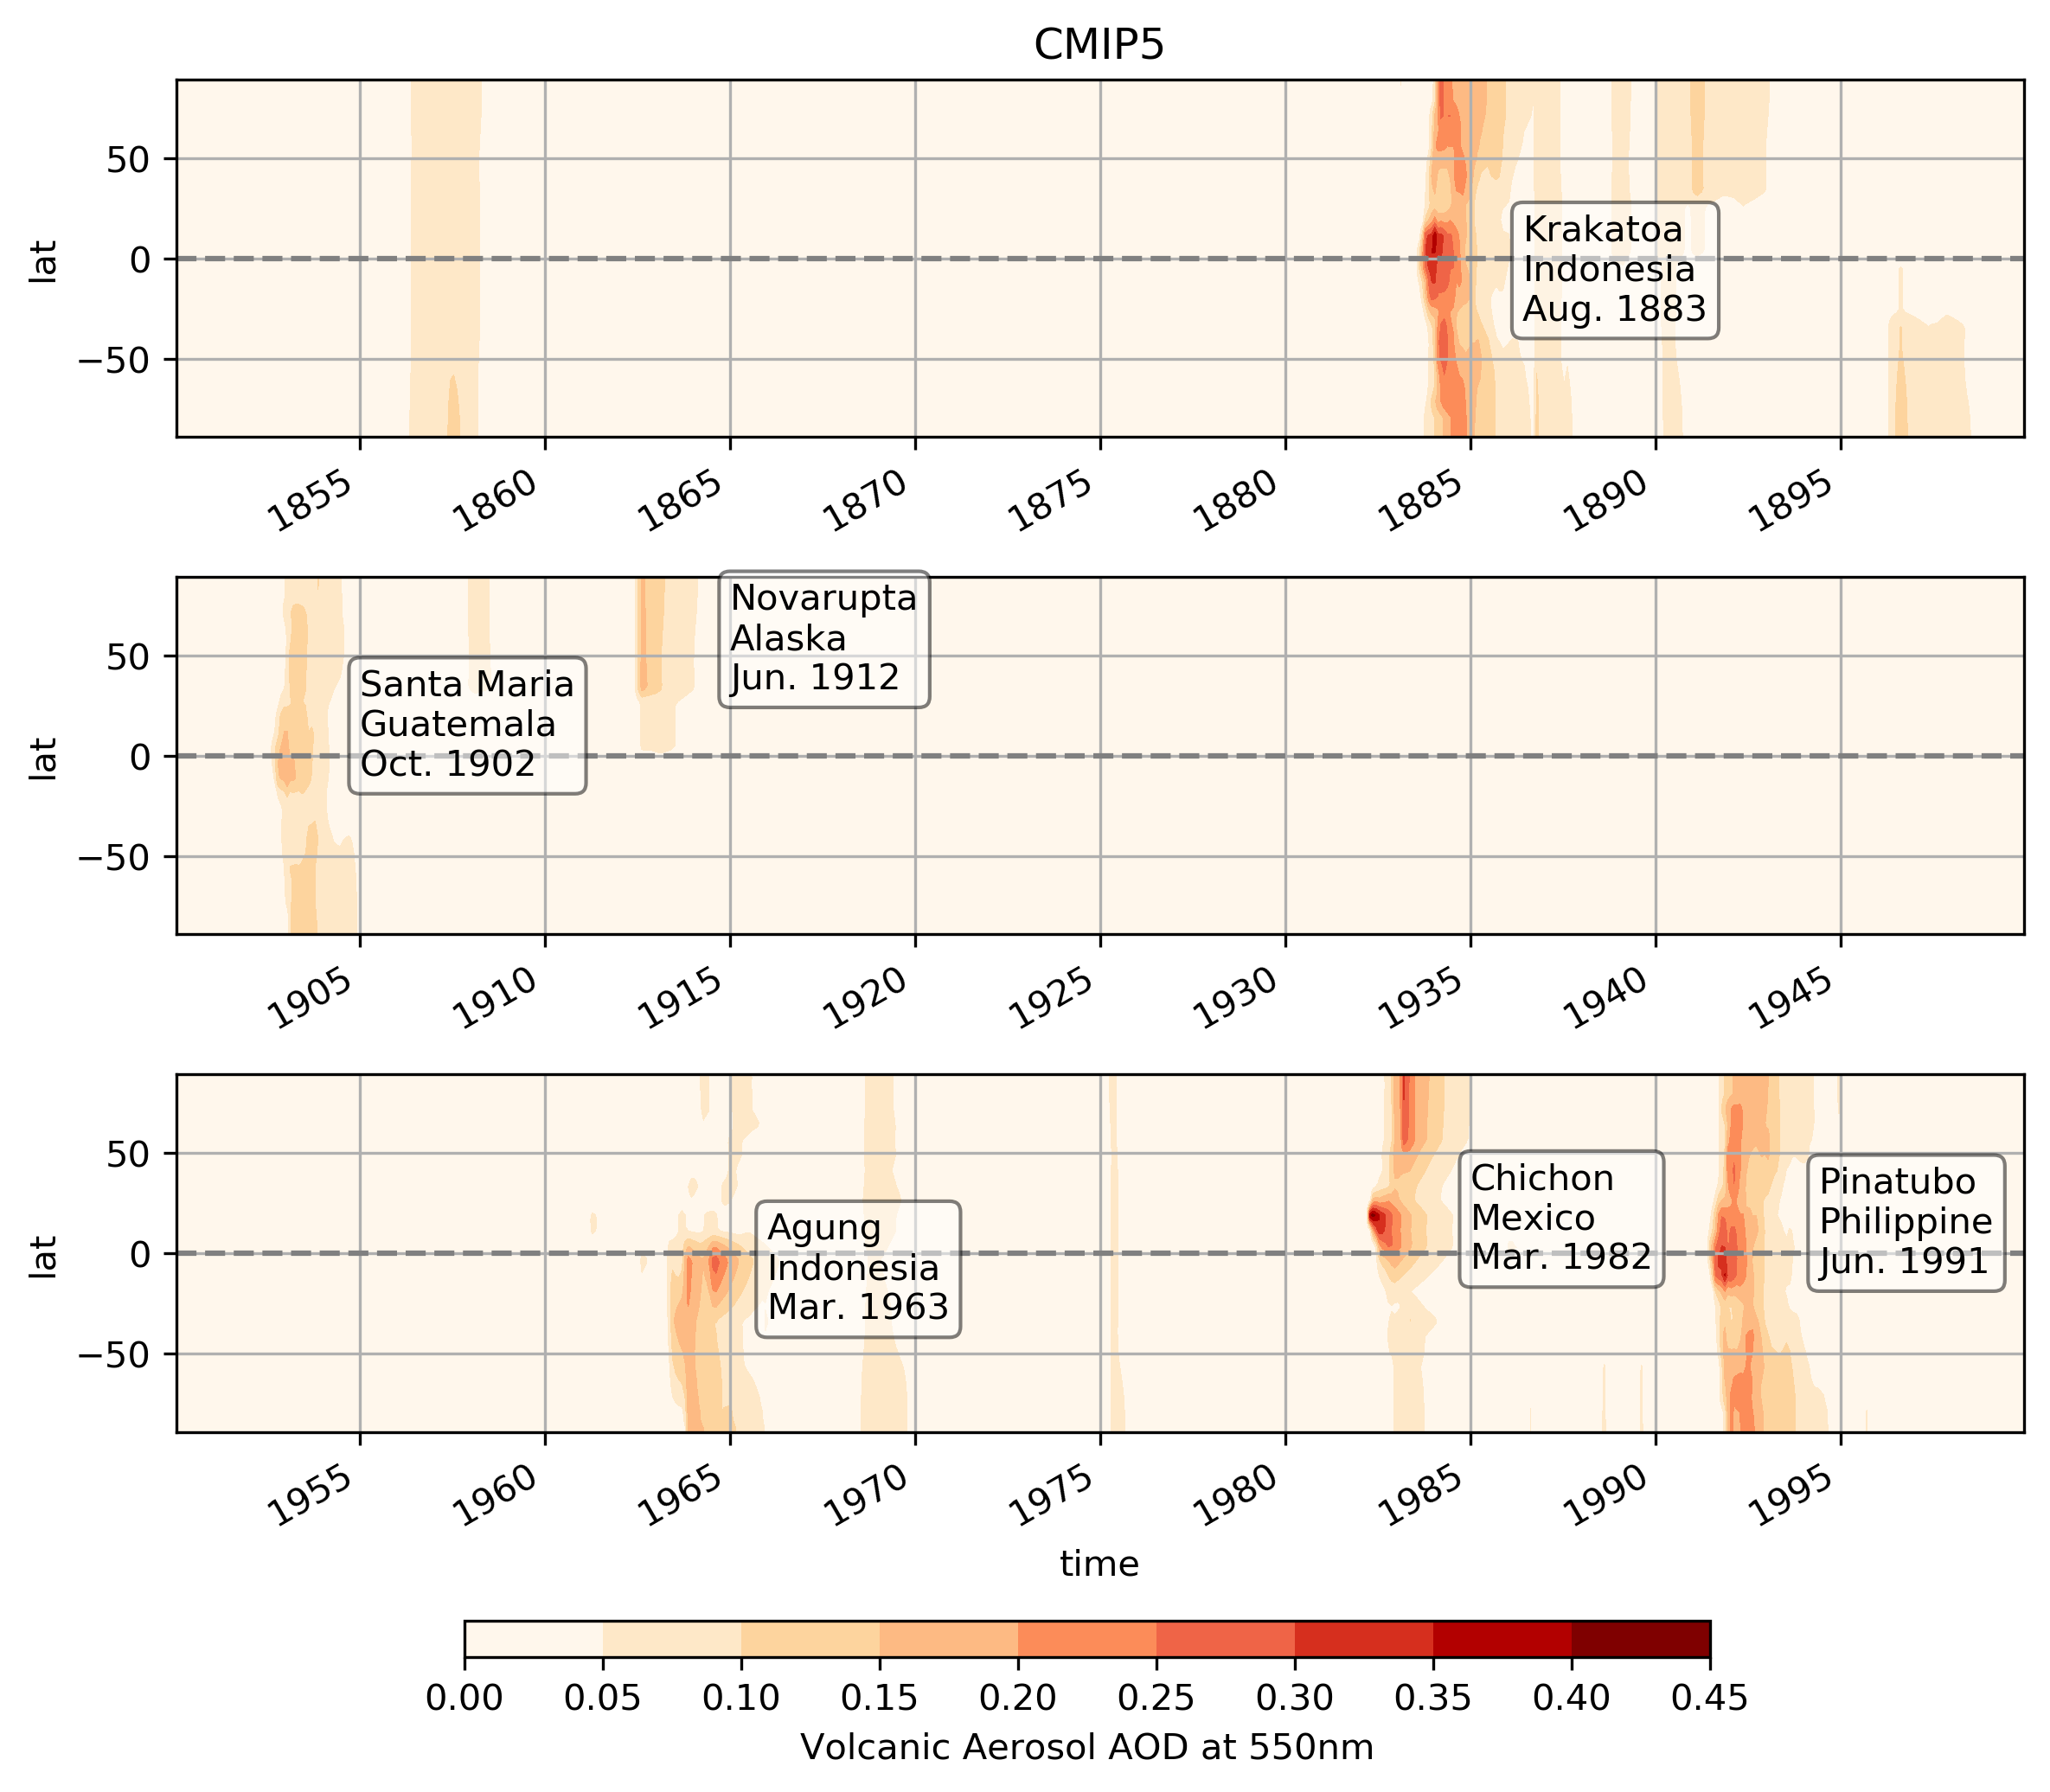

In [177]:
fig, axes = plt.subplots(3,1,figsize=(8,7), sharey=True)
cmap = 'OrRd'
levels = np.arange(0,0.46,0.05)

ax = axes[0]
# plt.sca(ax)
da_.sel(time=slice('1850', '1899')).plot.contourf(ax=ax, x='time', cmap=cmap, levels=levels,
                                                 add_colorbar=False)

ax.set_title(cmip)
ax.set_xlabel('')
ax.set_ylabel('lat')
ax.grid(True)
ax.axhline(0, color='gray', ls='--')
ax.text('1886-06', -6, 'Krakatoa\nIndonesia\nAug. 1883', va='center', bbox=bbox)

ax = axes[1]
# plt.sca(ax)
da_.sel(time=slice('1900', '1949')).plot.contourf(ax=ax, x='time', cmap=cmap, levels=levels,
                                                 add_colorbar=False)
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('lat')
ax.grid(True)
ax.axhline(0, color='gray', ls='--')
ax.text('1915-01', 58, 'Novarupta\nAlaska\nJun. 1912', va='center', bbox=bbox)
ax.text('1905-01', 15, 'Santa Maria\nGuatemala\nOct. 1902', va='center', bbox=bbox)


ax = axes[2]
im = da_.sel(time=slice('1950', '1999')).plot.contourf(ax=ax, x='time', cmap=cmap, levels=levels,
                                                      add_colorbar=False)
ax.set_title('')
ax.grid(True)
ax.set_ylabel('lat')
ax.axhline(0, color='gray', ls='--')
ax.text('1994-06', 15, 'Pinatubo\nPhilippine\nJun. 1991', va='center', bbox=bbox)
ax.text('1985-01', 17, 'Chichon\nMexico\nMar. 1982', va='center', bbox=bbox)
ax.text('1966-01', -8, 'Agung\nIndonesia\nMar. 1963', va='center', bbox=bbox)


#yticks2lat(np.arange(-60,61,30))

ax = fig.add_axes((.23,.08,.6,.02))
plt.colorbar(im, cax=ax, orientation='horizontal', label=f'Volcanic Aerosol AOD at 550nm', extend='both')

for ax in axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=30, horizontalalignment='right')

plt.tight_layout(rect=(0,.1,1,1))
if figname is not None:
    plt.savefig(figname)

if __name__ == '__main__' and False:
    tformat = '%Y-%m-%d %H:%M:%S'
    t0 = datetime.now()
    print('[start]:', t0.strftime(tformat))
    
    t1 = datetime.now()
    print('[end]:', t1.strftime(tformat))
    print('[total time]:', f'{(t1-t0).seconds:,} seconds')